# Time Series Momentum Strategy - G9 Currencies 

In [695]:
import pandas as pd
import numpy  as  np
from datetime import datetime, timedelta

### 1. Data Download 

In [696]:
fx_df = pd.read_csv("G10_FX_HI_LO_CLOSE.csv", skiprows=0, header = None)

## 2. Data Split

In [697]:
train_size = int(fx_df.shape[0] * 0.8585)
train_size

2347

In [698]:
i = 1 
while (i < fx_df.shape[1]):
    columns_list = [0]
    columns_list.append(i)
    for j in range(i+1,fx_df.shape[1],1):
        if (fx_df[i][0] == fx_df[j][0]):
            columns_list.append(j)
            if (j == fx_df .shape[1]-1):
                df_ = pd.read_csv('G10_FX_HI_LO_CLOSE.csv', usecols =columns_list,skiprows=1,header =0)
                df_["Dates"] = pd.to_datetime(df_["Dates"])
                df_.set_index("Dates")
                df_.columns = ["Dates","High","Low","Last"]
                df_.to_csv(f'FX_{fx_df[i][0]}.csv')
                break
            
        else:
            df_ = pd.read_csv('G10_FX_HI_LO_CLOSE.csv', usecols =columns_list,skiprows=1,header =0)
            df_["Dates"] = pd.to_datetime(df_["Dates"])
            df_.set_index("Dates")
            df_.columns = ["Dates","High","Low","Last"]
            df_.to_csv(f'FX_{fx_df[i][0]}.csv')
            break
    

    if ( j == fx_df.shape[1]-1):
        break
    else:
        i = j 
        columns_list.clear()

## 2. Data Frame for the list of currencies - Training Data set 

In [699]:
FX_SEK =  pd.read_csv("FX_SEK.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]
FX_DKK =  pd.read_csv("FX_DKK.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]
FX_CHF =  pd.read_csv("FX_CHF.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]
FX_NZD =  pd.read_csv("FX_NZD.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]
FX_AUD =  pd.read_csv("FX_AUD.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]
FX_CAD=  pd.read_csv("FX_CAD.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]
FX_GBP=  pd.read_csv("FX_GBP.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]
FX_JPY = pd.read_csv("FX_EUR.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]
FX_EUR = pd.read_csv("FX_EUR.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]

## 3. Data Frame for the list of currencies - for Validation of portfolio PNL

In [700]:
FX_SEK_validation =  pd.read_csv("FX_SEK.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]
FX_DKK_validation =  pd.read_csv("FX_DKK.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]
FX_CHF_validation =  pd.read_csv("FX_CHF.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]
FX_NZD_validation =  pd.read_csv("FX_NZD.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]
FX_AUD_validation =  pd.read_csv("FX_AUD.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]
FX_CAD_validation=  pd.read_csv("FX_CAD.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]
FX_GBP_validation=  pd.read_csv("FX_GBP.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]
FX_JPY_validation = pd.read_csv("FX_EUR.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]
FX_EUR_validation = pd.read_csv("FX_EUR.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]
FX_SEK_validation.head(15)


,High,Low,Last
Dates,,,
2020-01-01,0.1069,0.1067,0.1068
2020-02-01,0.1073,0.1067,0.1068
2020-03-01,0.1069,0.1057,0.1064
2020-06-01,0.1065,0.1060,0.1064
2020-07-01,0.1065,0.1056,0.1058
2020-08-01,0.1061,0.1055,0.1057
2020-09-01,0.1059,0.1053,0.1054
2020-10-01,0.1055,0.1050,0.1053
2020-01-13,0.1057,0.1049,0.1056


## 4. main database of all the G9 currency  

In [701]:
all_df = [FX_SEK,FX_DKK,FX_CHF,FX_NZD,FX_AUD,FX_CAD,FX_GBP,FX_JPY,FX_EUR]

## 4. DataFrame - CLose Price of all the G9 currency pairs 

In [702]:
close_df = pd.concat([FX_SEK["Last"],FX_DKK["Last"],FX_CHF["Last"],FX_NZD["Last"] ,FX_AUD["Last"],FX_CAD["Last"],FX_GBP["Last"],FX_JPY["Last"],FX_EUR["Last"]],axis =1)

close_df.columns = {"FX_SEK","FX_DKK","FX_CHF","FX_NZD","FX_AUD","FX_CAD","FX_GBP","FX_JPY","FX_EUR"}

available_symbols = close_df.columns

# 5. TSMOM strategy -

## 5.1 Function to generate Trend Signal 

In [703]:
def GetTradingSignal(Close_price):
    '''
    TREND Trading Signal
    - Uses the t-statistics of historical daily log-returns to reflect the strength of price movement trend
    - TREND Signal Conditions:
    t-stat > 1 => TREND Signal = 1
    t-stat < 1 => TREND Signal = -1
    -1 < t-stat < 1 => TREND Signal = t-stat
    '''
    log_returns = np.log(Close_price/Close_price.shift(1)).dropna()
    mean = np.mean(log_returns)
    std = np.std(log_returns)
    n = len(log_returns)
    t_stat = mean/(std/np.sqrt(n))

    # cap holding at 1 and -1
    return np.clip(t_stat, a_max=1, a_min=-1)

## 5.2 Function to Volatility 

In [704]:
def GetYZVolatility(all_df):

    """ Formula: sigma_YZ^2 = sigma_OJ^2 + self.k * sigma_SD^2 + (1-self.k)*sigma_RS^2 (Equation 20 in [1])
        where,  sigma_OJ - (Overnight Jump Volitility estimator)
                sigma_SD - (Standard Volitility estimator)
                sigma_RS - (Rogers and Satchell Range Volatility estimator)"""
    
    YZ_volatility = []
    for i,j in enumerate(all_df):
        today = pd.to_datetime(all_df[i].index[-1]).strftime('%Y-%m-%d')
        diff = pd.to_datetime(pd.to_datetime(all_df[i].index[-1]) - timedelta(35)).strftime('%Y-%m-%d')
        past_month_ohlc = all_df[i].loc[diff:today]
        high,low,close,open = past_month_ohlc.High,past_month_ohlc.Low, past_month_ohlc.Last,past_month_ohlc.Last
        estimation_period = past_month_ohlc.shape[0]
        k = 0.34 / (1.34 + (estimation_period + 1) / (estimation_period - 1))
        #sigma_OJ (overnight jump => stdev of close-to-open log returns)
        open_to_close_log_returns = np.log(close / close.shift(1))
        open_to_close_log_returns = open_to_close_log_returns[np.isfinite(open_to_close_log_returns)]
        sigma_OJ = np.std(open_to_close_log_returns)
        # sigma_SD (standard deviation of close-to-close log returns)
        close_to_close_log_returns = np.log(close / close.shift(1))
        close_to_close_log_returns = close_to_close_log_returns[np.isfinite(close_to_close_log_returns)]
        sigma_SD = np.std(close_to_close_log_returns)

        # sigma_RS (Rogers and Satchell (1991))
        h = np.log(high / open)
        l = np.log(low / open)
        c = np.log(close / open)
        sigma_RS_daily = (h * (h - c) + l * (l - c)) ** 0.5
        sigma_RS_daily = sigma_RS_daily[np.isfinite(sigma_RS_daily)]
        sigma_RS = np.mean(sigma_RS_daily)

        # daily Yang and Zhang volatility
        sigma_YZ = np.sqrt(sigma_OJ ** 2 + k * sigma_SD ** 2 + (1 - k) * sigma_RS ** 2)

        # append annualized volatility to the list
        YZ_volatility.append(sigma_YZ * np.sqrt(252))


       
    return YZ_volatility

## 5.3 Function to determine correlation factor between different Currencies 

In [705]:
def GetCorrelationFactor(history,trade_signals,available_symbols):
    '''
    Correlation Factor, is a function of the average pairwise correlation of all portfolio contituents
    - the calculation is based on past three month pairwise correlation
    - Notations:
        rho_bar - average pairwise correlation of all portfolio constituents
        CF_rho_bar - the correlation factor as a function of rho_bar'''

    # Get the past three month simple daily returns for all securities
    diff = pd.to_datetime(pd.to_datetime(close_df.index[-1]) - timedelta(92)).strftime('%Y-%m-%d')
    past_three_month_returns = close_df.pct_change().loc[diff:]
    past_three_month_returns.corr()
    
    # Get number of assets 
    N_assets = len(available_symbols)

    # Get the pairwise signed correlation matrix for all assets
    correlation_matrix = past_three_month_returns.corr()

    # Calculate rho_bar
    summation = 0
    for i in range(N_assets - 1):
        for temp in range(N_assets - 1 - i):
            j = i + temp + 1
            x_i = trade_signals.values[i]
            x_j = trade_signals.values[j]
            rho_i_j = correlation_matrix.iloc[i, j]
            summation += x_i * x_j * rho_i_j

    # Equation 14 in [1]
    rho_bar = (2 * summation) / (N_assets * (N_assets - 1))

    # Calculate the correlation factor (CF_rho_bar)
    # Equation 18 in [1]
    return np.sqrt(N_assets / (1 + (N_assets - 1) * rho_bar)) 

## 5.4 Function to generate portfolio weights for different currency  
-  weights allocation is based on  volaiity 
-  Also have considered correlation factor 

In [706]:
from sklearn.preprocessing import StandardScaler
def Portfolio_Creation(close_df,all_df,available_symbols,portfolio_target_sigma):
    
    #print (history.head(5))
    N_assets = len(available_symbols)
    AssetWeight = []
    '''
    Monthly rebalance at the beginning of each month.
    Portfolio weights for each constituents are calculated based on Baltas and Kosowski weights.
    '''

    '''Monthly Rebalance Execution'''
    """
    # dataframe that contains the historical data for all securities
    history = self.History(self.Securities.Keys, self.OneYear, Resolution.Daily)
    history.replace(0, np.nan, inplace=True)

    # Get the security symbols are are in the history dataframe
    available_symbols = list(set(history.index.get_level_values(level=0)))

    # Liquidate symbols that are not in the history dataframe anymore
    for security in self.Securities.Keys:
        if security.Value not in available_symbols:
            self.Liquidate(security, 'Not found in history request')
    """
    # Get the trade signals and YZ volatility for all securities
    trade_signals = GetTradingSignal(close_df)
    TopCurrency = pd.DataFrame(GetTradingSignal(close_df)).sort_values(by =0,ascending=False).head(3)
    #print("TopCurrency as per T-Stat: {}".format(TopCurrency))
    BottomCurrency = pd.DataFrame(GetTradingSignal(close_df)).sort_values(by =0,ascending=False).tail(3)
    #print("BottomCurrencies as per T-Stat: {}".format(BottomCurrency))
    FX_Pairs_Portfolio = list(pd.concat([TopCurrency , BottomCurrency]).index)
    #'FX_CHF', 'FX_DKK', 'FX_AUD', 'FX_GBP', 'FX_NZD', 'FX_SEK']
    all_df1 = [FX_SEK,FX_DKK,FX_CHF,FX_NZD,FX_AUD,FX_GBP]
    volatility =  GetYZVolatility(all_df1)   
    close_df = close_df[FX_Pairs_Portfolio]
    available_symbols = FX_Pairs_Portfolio
    trade_signals = pd.concat([TopCurrency , BottomCurrency])
    # Get the correlation factor
    CF_rho_bar = GetCorrelationFactor(close_df, trade_signals, available_symbols)
    # Rebalance the portfolio according to Baltas and Kosowski suggested weights
    N_assets = len(available_symbols)
    symbol_port = []
    weight_port = []
    final_Normalized_weight = []
    for symbol, signal, vol in zip(available_symbols, trade_signals.values, volatility):

        # Baltas and Kosowski weights (Equation 19 in [1])
        print
        weight = (signal * portfolio_target_sigma * CF_rho_bar) / (N_assets * vol)
        symbol_port.append(symbol)
        weight_port.append(weight)
        
        #SetHoldings(symbol, weight)

    # Set next rebalance time
    #self.nextRebalance = Expiry.EndOfMonth(self.Time)
    data = StandardScaler().fit_transform(weight_port)
    for i,j in zip(symbol_port,data):
        final_Normalized_weight.append([i,j[0]])
    
    
    return final_Normalized_weight

## Weights Allocated to different Currencies : T =0 

In [707]:
Weights = Portfolio_Creation(close_df,all_df,available_symbols,0.4)
Weights1 = pd.DataFrame(Weights)
Weights1.columns = {"Currency","Weight"}
Weights_df= Weights1.set_index("Weight")
Weights_df.index

Index(['FX_EUR', 'FX_GBP', 'FX_JPY', 'FX_SEK', 'FX_DKK', 'FX_NZD'], dtype='object', name='Weight')

In [708]:
TopCurrency = pd.DataFrame(GetTradingSignal(close_df)).sort_values(by =0,ascending=False).head(3)
BottomCurrency = pd.DataFrame(GetTradingSignal(close_df)).sort_values(by =0,ascending=False).tail(3)
z = pd.concat([TopCurrency , BottomCurrency])
z.values[1]

array([-0.42256344])

In [709]:
today = pd.to_datetime(FX_SEK_validation.index[1]).strftime('%Y-%m-%d')
add = pd.to_datetime(pd.to_datetime(FX_SEK_validation.index[1]) + timedelta(450)).strftime('%Y-%m-%d')
FX_DKK = pd.DataFrame(FX_DKK_validation["Last"].loc[today:add])
FX_SEK = pd.DataFrame(FX_SEK_validation["Last"].loc[today:add])
#FX_CHF_F1M = pd.DataFrame(FX_CHF_validation["Last"].loc[today:add])
FX_NZD = pd.DataFrame(FX_NZD_validation["Last"].loc[today:add])
#FX_CAD_F1M = pd.DataFrame(FX_CAD_validation["Last"].loc[today:add])
#FX_AUD_F1M = pd.DataFrame(FX_AUD_validation["Last"].loc[today:add])
FX_JPY = pd.DataFrame(FX_JPY_validation["Last"].loc[today:add])
FX_GBP = pd.DataFrame(FX_GBP_validation["Last"].loc[today:add])
FX_EUR = pd.DataFrame(FX_EUR_validation["Last"].loc[today:add])

In [710]:
#OneMonth = pd.concat([FX_SEK_F1M,FX_CHF_F1M,FX_NZD_F1M,FX_CAD_F1M,FX_AUD_F1M,FX_JPY_F1M,FX_GBP_F1M,FX_EUR_F1M],axis =1)
#OneMonth.columns = ["FX_SEK_F1M","FX_CHF_F1M","FX_NZD_F1M","FX_CAD_F1M","FX_AUD_F1M","FX_JPY_F1M","FX_GBP_F1M","FX_EUR_F1M"]
PNL_df = pd.concat([FX_DKK,FX_SEK,FX_NZD,FX_JPY,FX_GBP,FX_EUR],axis =1)
PNL_df.columns = ["FX_DKK","FX_SEK","FX_NZD","FX_JPY","FX_GBP","FX_EUR"]

In [711]:
Total_Cash = 10000
PNL_df.index = pd.to_datetime(PNL_df.index)
fx_df_return = PNL_df.pct_change().dropna()
fx_df_return

,FX_DKK,FX_SEK,FX_NZD,FX_JPY,FX_GBP,FX_EUR
Dates,,,,,,
2020-03-01,-0.001338,-0.003745,-0.005670,-0.000985,-0.004717,-0.000985
2020-06-01,0.003349,0.000000,0.001651,0.003226,0.006726,0.003226
2020-07-01,-0.004005,-0.005639,-0.004794,-0.003930,-0.003417,-0.003930
2020-08-01,-0.004021,-0.000945,0.000602,-0.004304,-0.002209,-0.004304
2020-09-01,0.000000,-0.002838,-0.004664,0.000090,-0.002291,0.000090
...,...,...,...,...,...,...
2021-04-20,0.000000,-0.004198,-0.001392,-0.000083,-0.003504,-0.000083
2021-04-21,-0.000618,0.002530,0.005296,-0.000083,-0.000431,-0.000083
2021-04-22,-0.001236,-0.002523,-0.005684,-0.001662,-0.006604,-0.001662


In [712]:
cumulativePNL_df = fx_df_return.cumsum(axis =0)
cumulativePNL_df
fx_df_return.columns 

Index(['FX_DKK', 'FX_SEK', 'FX_NZD', 'FX_JPY', 'FX_GBP', 'FX_EUR'], dtype='object')

In [713]:
Total_Cash = 10000
i =1
Weights_df.loc["FX_EUR"][0]
for i in fx_df_return.columns:
    print("Currency : {} , Currency Weight {} ".format(i,Weights_df.loc[i][0]*Total_Cash))
    cumulativePNL_df["PNL_"+i] = cumulativePNL_df[i].apply(lambda x : x * (Weights_df.loc[i][0]*Total_Cash))
    
cumulativePNL_df["Portfolio_PNL"] = cumulativePNL_df.iloc[:,5:].sum(axis =1)
cumulativePNL_df.head(2)

print("\n \n  Total Cumulative Profit : {}". format(cumulativePNL_df["Portfolio_PNL"][-1]))

Currency : FX_DKK , Currency Weight -10602.017447613283 
Currency : FX_SEK , Currency Weight -10608.952737470694 
Currency : FX_NZD , Currency Weight 492.66623350170323 
Currency : FX_JPY , Currency Weight -1141.7173507812743 
Currency : FX_GBP , Currency Weight 2727.2414950365505 
Currency : FX_EUR , Currency Weight 19132.779807326995 

 
  Total Cumulative Profit : -480.9131662460725


In [714]:
print("Total CUmulative Profit : {}". format(cumulativePNL_df["Portfolio_PNL"][-1]))

Total CUmulative Profit : -480.9131662460725


# Graph : Daily Return and Cummulative Return 

No handles with labels found to put in legend.


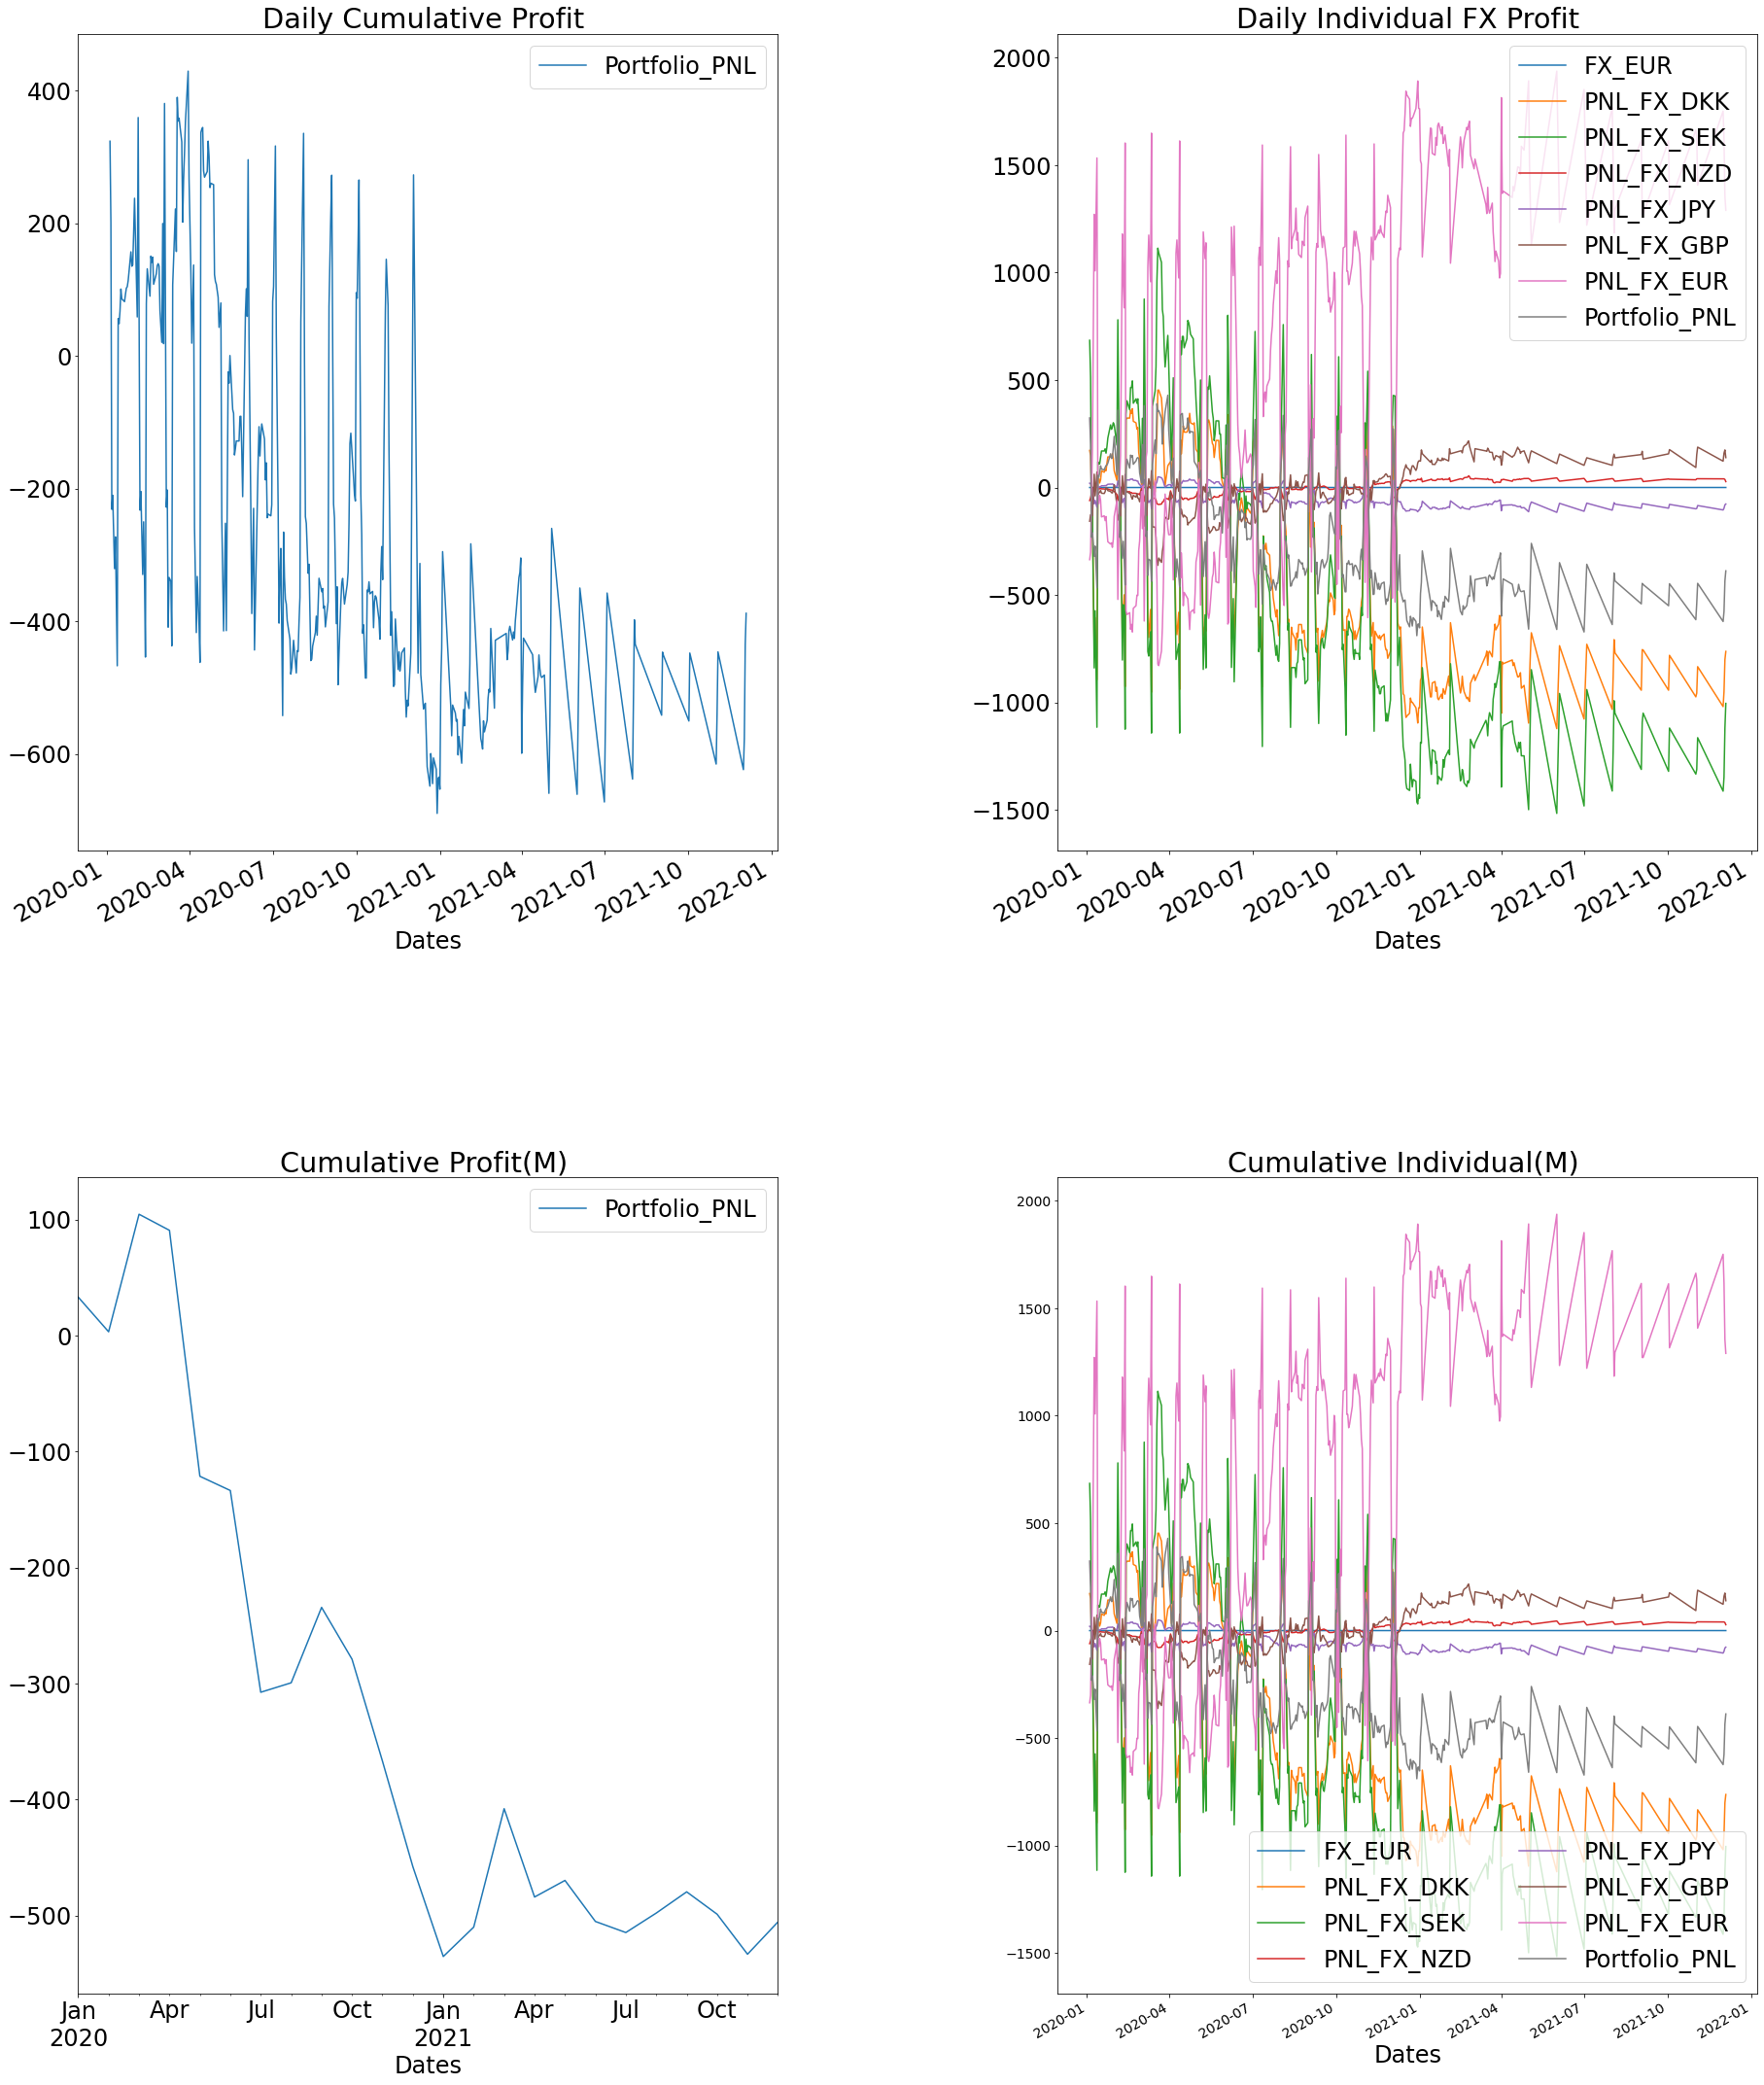

In [716]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(30,40))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


plt.rcParams.update({'font.size': 24})
plt.tick_params(labelsize=14)

cumulativePNL_df[["Portfolio_PNL"]].plot(title = "Daily Cumulative Profit " ,ax=axes[0,0])
plt.rcParams.update({'font.size': 24})
plt.tick_params(labelsize=14)
cumulativePNL_df.iloc[:,5:].plot(title = "Daily Individual FX Profit",ax=axes[0,1])
plt.rcParams.update({'font.size': 24})
plt.tick_params(labelsize=14)
plt.legend(loc='lower right', ncol=2)

cumulativePNL_df[["Portfolio_PNL"]].resample('M').mean().plot(title = "Cumulative Profit(M) " ,ax=axes[1,0])
plt.rcParams.update({'font.size': 24})
plt.tick_params(labelsize=14)
cumulativePNL_df.iloc[:,5:].plot(title = "Cumulative Individual(M) ",ax=axes[1,1])
plt.rcParams.update({'font.size': 24})
plt.tick_params(labelsize=14)
plt.legend(loc='lower right', ncol=2)